<a href="https://colab.research.google.com/github/aj-39719/Arcadis-Pipe-Data-Analysis/blob/main/Arcadis_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import the data**

In [ ]:
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive/Colab Notebooks/')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/example.work.orders Sep 18.csv")   

In [ ]:
data.head()

,JOB_ID,JOB_TYPE,DEPTH_M,DIAMETER_MM,MATERIAL,LENGTH_M,JOB_COST
0,Job 1,Replace,2.19,200,ST,31.55,19847.644300
1,Job 2,Replace,2.27,63,AC,15.14,4476.588985
2,Job 3,Repair,3.64,450,ST,15.17,16871.484850
3,Job 4,Replace,2.28,200,AC,15.64,11158.144200
4,Job 5,Replace,2.40,200,ST,39.23,16913.611580


### **Structural investigation of Data**

In [ ]:
# Lets see the rows and columns in our data
data.shape

(5000, 7)

In [ ]:
#Lets see the different data types in our data
data.dtypes

JOB_ID          object
JOB_TYPE        object
DEPTH_M        float64
DIAMETER_MM      int64
MATERIAL        object
LENGTH_M       float64
JOB_COST       float64
dtype: object

### **Quality investigation of Data**

Checking for missing or NA values


In [ ]:
data.isna().any()

JOB_ID         False
JOB_TYPE       False
DEPTH_M        False
DIAMETER_MM    False
MATERIAL       False
LENGTH_M       False
JOB_COST        True
dtype: bool

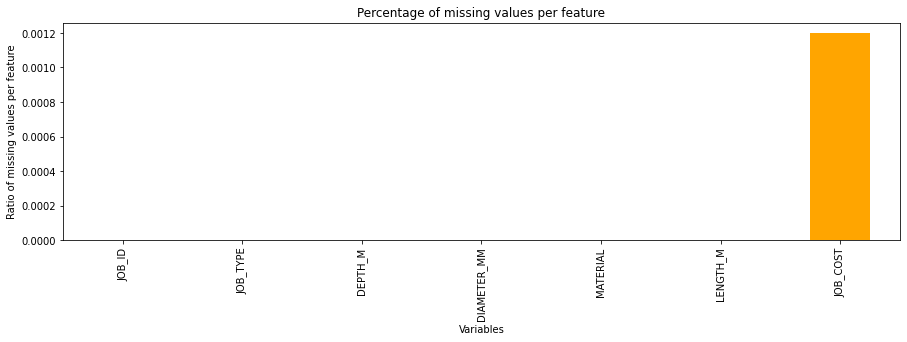

In [ ]:
data.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    color = "orange",
    title = "Percentage of missing values per feature")
    ylabel = "Ratio of missing values per feature",
    xlabel = "Variables");

Interpolating the missing values

In [ ]:
# Lets interpolate and fill the missing values
data = data.interpolate()

In [ ]:
# Cross-checking
data.isna().any()

JOB_ID         False
JOB_TYPE       False
DEPTH_M        False
DIAMETER_MM    False
MATERIAL       False
LENGTH_M       False
JOB_COST       False
dtype: bool

### **Exploring the Data**

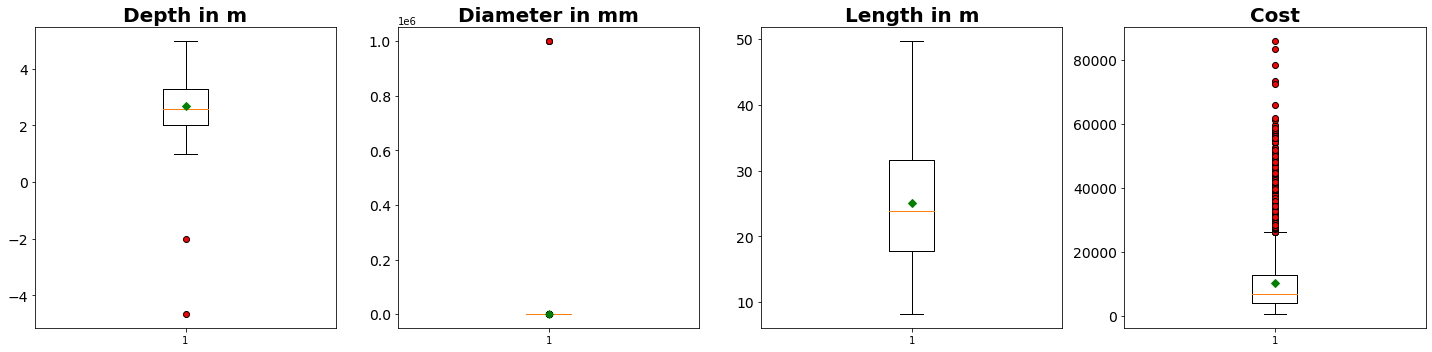

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows = 1, ncols = 4, figsize=(20,5))
redcircle = dict(markerfacecolor = 'red', marker = 'o')
mean_shape = dict(markerfacecolor = 'green', marker = 'D', markeredgecolor = 'green')

ax1.boxplot(data["DEPTH_M"], flierprops=redcircle,
            showmeans = True, meanprops = mean_shape)
ax1.set_title("Depth in m", fontsize=20, fontweight='bold')
ax1.tick_params(axis='y', labelsize=14)

ax2.boxplot(data["DIAMETER_MM"], flierprops=redcircle,
            showmeans = True, meanprops = mean_shape)
ax2.set_title("Diameter in mm", fontsize=20, fontweight='bold')
ax2.tick_params(axis='y', labelsize=14)

ax3.boxplot(data["LENGTH_M"], flierprops=redcircle,
            showmeans = True, meanprops = mean_shape)
ax3.set_title("Length in m", fontsize=20, fontweight='bold')
ax3.tick_params(axis='y', labelsize=14)

ax4.boxplot(data["JOB_COST"], flierprops=redcircle,
            showmeans = True, meanprops = mean_shape)
ax4.set_title("Cost", fontsize=20, fontweight='bold')
ax4.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

Hence, we see that there are some major outliers in this data set which need to be appropriateky dealt with. So, we define some functions below to achieve this.

### **Dealing with  Outliers**

In [ ]:
def outliers(data, ft):
  '''
  A function for returning a list of outlier indexes
  '''
  Q1 = data[ft].quantile(0.25) #First quantile
  Q3 = data[ft].quantile(0.75) #Third quantile
  
  #Lets define our inter-quantile range - 
  IQR = Q3 - Q1

  #Lets define our upper and lower bounds - 
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR

  ls = data.index[(data[ft] < lower_bound) | (data[ft] > upper_bound)]
  return ls

def remove(data, ls):
  '''
  A function for dropping outlier values based on input indexes
  '''
  ls = sorted(set(ls))
  data = data.drop(ls)
  return data

In [ ]:
# Lets generate a list of outlier indexes
index_list = []
for feature in ['DEPTH_M','DIAMETER_MM','LENGTH_M']:
  index_list.extend(outliers(data,feature))

In [ ]:
data = remove(data,index_list)

# Now lets check the shape of our modified data set
data.shape

(4876, 7)

### **Visualizing Numeric Data**

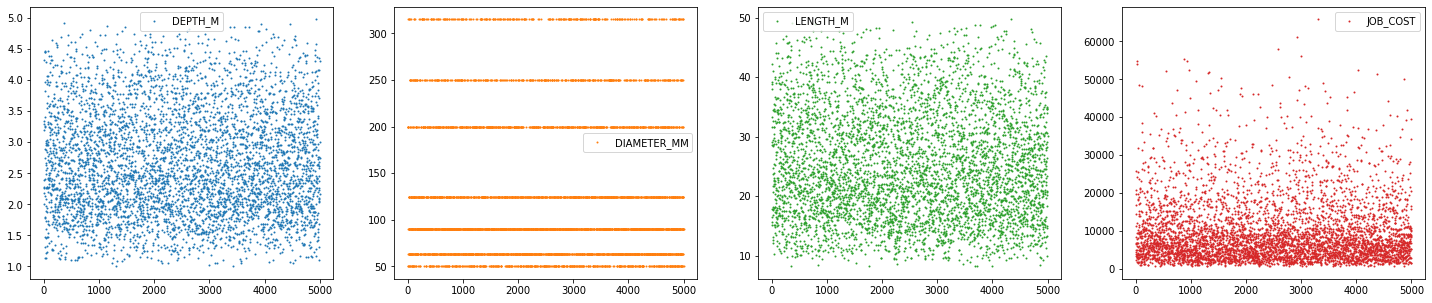

In [ ]:
data.plot(lw=0, # we dont want any lines
          marker="o",
          subplots=True,
          layout=(-1, 4), #The -1 means "as many as needed", while the 4 means to use 4 columns per row.
          figsize=(25, 5),
          markersize=1);

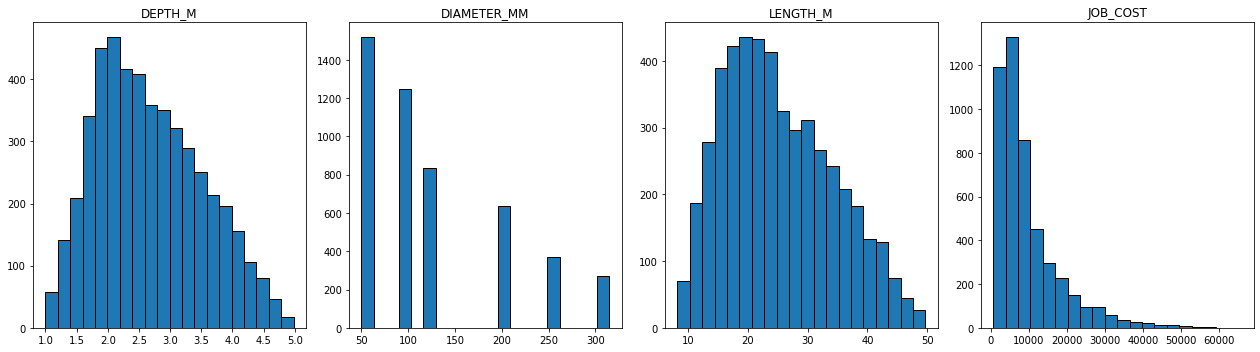

In [ ]:
# Plots the histogram for each numerical feature in a separate subplot
data.hist(bins=20, figsize=(22, 5), layout=(-1, 5), edgecolor="black", grid = False)
plt.tight_layout();

### **Visualizing Non-numeric data**

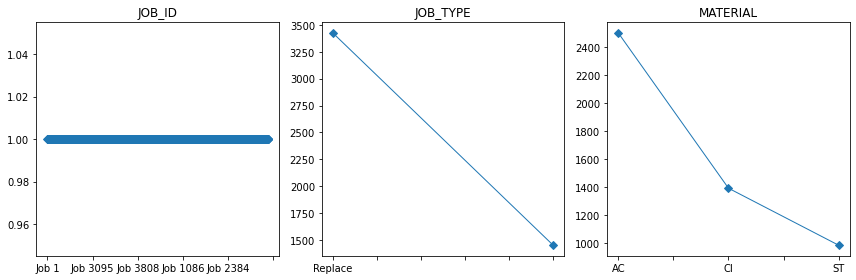

In [ ]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

# Identify non-numerical features
df_non_numerical = data.select_dtypes(exclude=["int64", "float64"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of unique value
    df_non_numerical[col].value_counts().plot(
        # Plots this information in a figure
        title=col, lw=1, marker="D", ax=ax)
    
plt.tight_layout();

### **Feature Correlation**

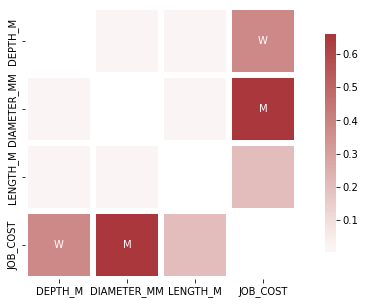

In [ ]:
import seaborn as sns
# Computes feature correlation
df_corr = data.corr(method="spearman")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(10, 5))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

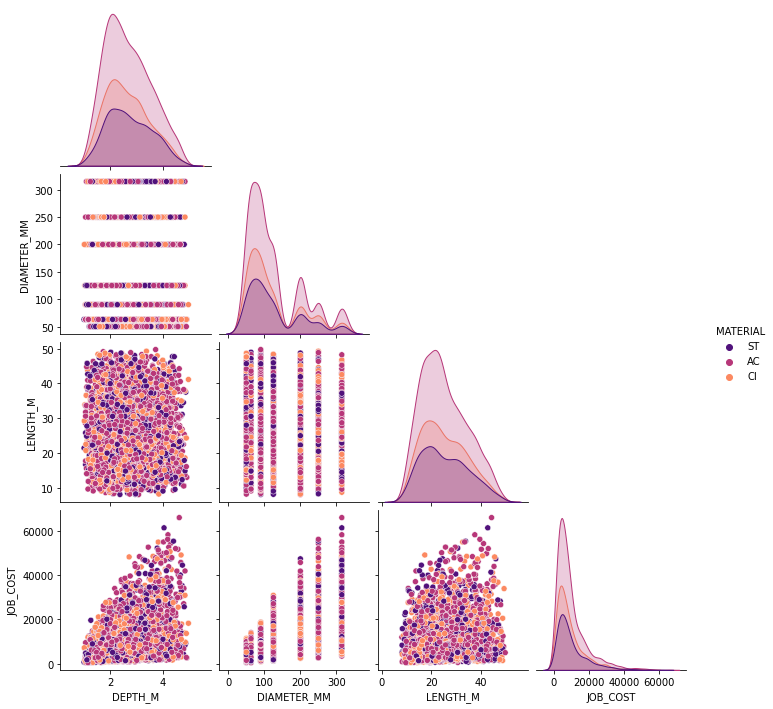

In [ ]:
sns.pairplot(data = data,hue="MATERIAL", palette = 'magma', corner = True)

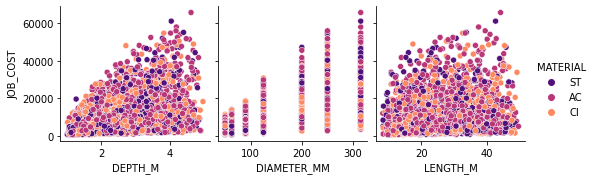

In [ ]:
sns.pairplot(data = data,x_vars = ["DEPTH_M","DIAMETER_MM","LENGTH_M"],y_vars = ["JOB_COST"],hue="MATERIAL", palette = 'magma');

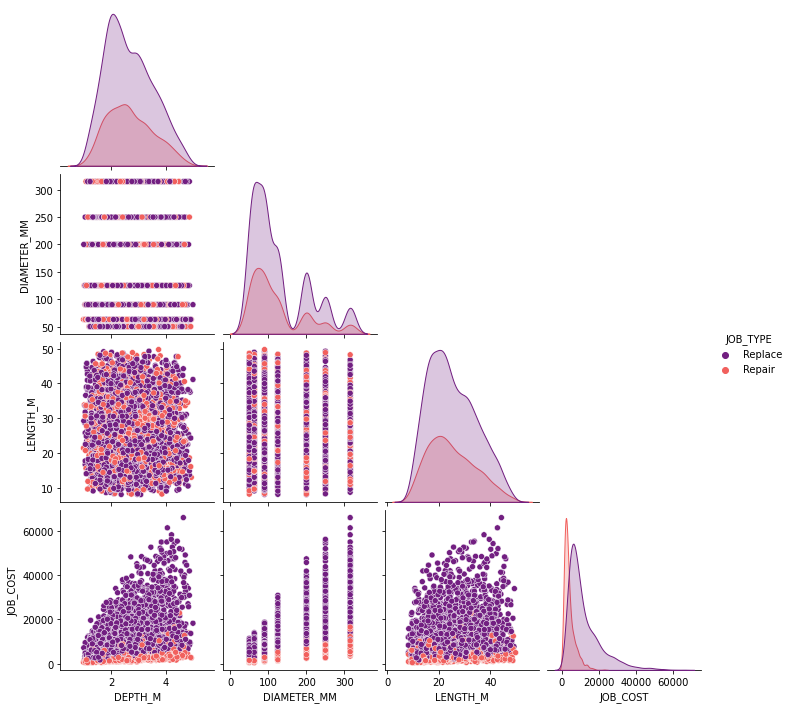

In [ ]:
import seaborn as sns

sns.pairplot(data = data,hue="JOB_TYPE", palette = 'magma', corner = True);

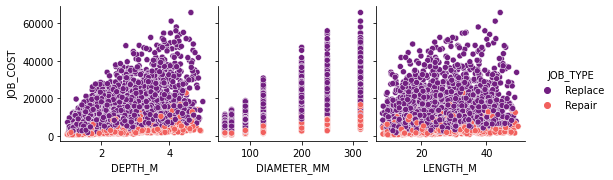

In [ ]:
sns.pairplot(data = data,x_vars = ["DEPTH_M","DIAMETER_MM","LENGTH_M"],y_vars = ["JOB_COST"],hue="JOB_TYPE", palette = 'magma');

### **Building a Linear Regression Model**

In [ ]:
# Our dependent variable 
Y = data['JOB_COST']

# Our independent variables
X = data[['DEPTH_M','DIAMETER_MM','LENGTH_M','MATERIAL','JOB_TYPE']]

# Our categorical variables
X = pd.get_dummies(data=X,columns=['MATERIAL','JOB_TYPE'])

In [ ]:
# Lets make sure our training dataset is of the correct structure
X.head()

,DEPTH_M,DIAMETER_MM,LENGTH_M,MATERIAL_AC,MATERIAL_CI,MATERIAL_ST,JOB_TYPE_Repair,JOB_TYPE_Replace
0,2.19,200,31.55,0,0,1,0,1
1,2.27,63,15.14,1,0,0,0,1
3,2.28,200,15.64,1,0,0,0,1
4,2.40,200,39.23,0,0,1,0,1
5,4.32,200,17.81,1,0,0,0,1


In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#lets split our dataset into two separate training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

#Building model
regr = linear_model.LinearRegression()

#Fitting the model
regr.fit(X_train, Y_train)

#Predict values using this model
predicted = regr.predict(X_test)

In [ ]:
#Print intercepts
print("Intercept: ", regr.intercept_)
#Print Coefficients
print("Coefficients:")
list(zip(X, regr.coef_))

Intercept:  -15690.006191812221
Coefficients:


[('DEPTH_M', 3695.3269466941993),
 ('DIAMETER_MM', 77.26852170227278),
 ('LENGTH_M', 166.48835152906605),
 ('MATERIAL_AC', -62.33470891387692),
 ('MATERIAL_CI', 11.908251123274326),
 ('MATERIAL_ST', 50.426457790601916),
 ('JOB_TYPE_Repair', -3866.9326817654837),
 ('JOB_TYPE_Replace', 3866.9326817654837)]

In [ ]:
diff = pd.DataFrame({'Actual value': Y_test, 'Predicted value': predicted})
diff.head()

,Actual value,Predicted value
2371,16478.643430,19300.301141
3441,8442.779540,13508.271245
272,19038.244550,23945.861851
2631,3103.032456,-181.984926
3518,5897.831695,9153.968317


### **Linear Regression Metrics**

In [ ]:
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(Y_test, predicted)
meanSqErr = metrics.mean_squared_error(Y_test, predicted)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(Y_test, predicted))

# Printing the model metrics
print('R squared: {:.2f}'.format(regr.score(X,Y)*100))
print('Mean Absolute Error: {:5.2f}'.format(meanAbErr))
print('Mean Square Error: {:5.2f}'.format(meanSqErr))
print('Root Mean Square Error: {:5.2f}'.format(rootMeanSqErr))

R squared: 81.99
Mean Absolute Error: 2582.33
Mean Square Error: 15787944.89
Root Mean Square Error: 3973.40


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


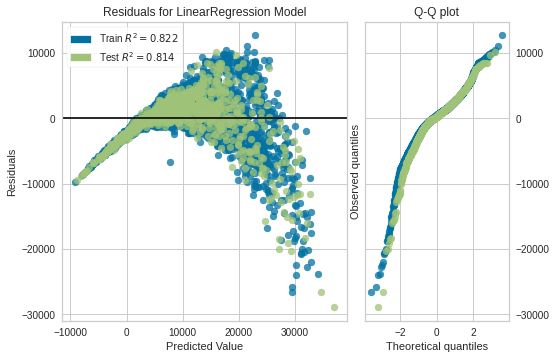

In [ ]:
# Residual Analysis

from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(regr, hist=False, qqplot=True);

visualizer.fit(X_train, Y_train);  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test);  # Evaluate the model on the test data
visualizer.show();                 # Finalize and render the figure

### **Neural Network Model**

In [ ]:
# lets do some necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Now lets build our model
def build_model():
  model = keras.Sequential([
  layers.Dense(64, activation=tf.nn.relu, input_shape = [len(X.keys())]),
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.01)
  model.compile(loss='mse',
                optimizer=optimizer, 
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100
history = model.fit(
X_train, Y_train,
epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................

### **Neural Network Metrics**

In [ ]:
 hist = pd.DataFrame(history.history)
 hist

,loss,mae,mse,val_loss,val_mae,val_mse
0,51716064.00,4896.949707,51716064.00,34638208.00,4168.633301,34638208.00
1,35723256.00,4220.678711,35723256.00,33676916.00,4105.970703,33676916.00
2,34400576.00,4138.172363,34400576.00,33918524.00,3923.035889,33918524.00
3,32819594.00,4008.865967,32819594.00,31791120.00,4037.252197,31791120.00
4,30866770.00,3856.942627,30866770.00,29060724.00,3551.515137,29060724.00
...,...,...,...,...,...,...
95,3796825.25,1074.092163,3796825.25,2715515.50,1025.539795,2715515.50
96,3935186.50,1132.474487,3935186.50,2435321.50,864.724731,2435321.50
97,3669580.25,1091.817749,3669580.25,2565133.50,861.914673,2565133.50
98,3930746.00,1129.990356,3930746.00,16266778.00,2739.546875,16266778.00


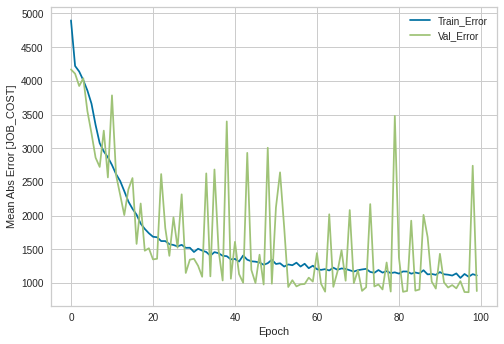

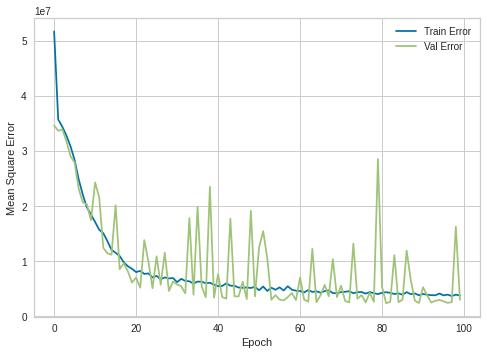

In [ ]:
#Lets plot the loss against epochs using the following function

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel ('Mean Abs Error [JOB_COST]')
  plt.plot(hist['epoch'], hist['mae'], label='Train_Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Val_Error')
  plt.legend ()
  
  
  plt.figure()
  plt.xlabel ('Epoch' )
  plt.ylabel ('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
  label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
  label = "Val Error")
  plt.legend()
  
plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(X_test,Y_test,verbose = 0)
print("Testing set mean absolute error: {:5.3f}".format(mae))

Testing set mean absolute error: 954.677


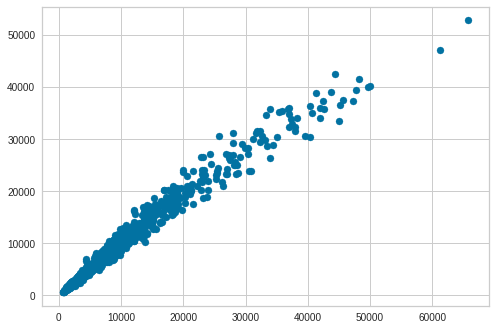

In [ ]:
# Plotting the predictions against the true values
test_predictions = model.predict(X_test)
plt.scatter(Y_test,test_predictions)
plt.show()

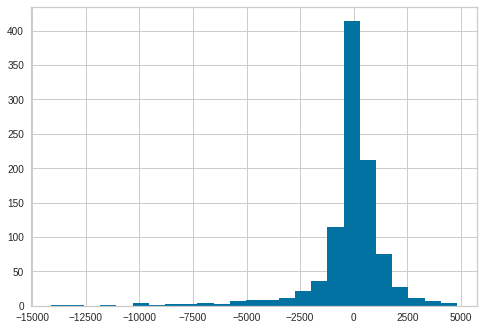

In [ ]:
# Finally, lets plot the distribution of our errors, a normal distribution is expected
error = test_predictions.flatten() - Y_test
plt.hist(error, bins = 25);